# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Determine Research Investigator Clusters based on their Research Areas

## Learning Objectives

At the end of the Mini Hackathon, you will be able to :

* Cluster similar research articles together using K-means
* Identify the top research investigators of those research articles

In [1]:
#@title Mini-hackathon Walkthrough
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.talentsprint.com/aiml/aiml_2020_b14_hyd/experiment_details_backup/Funding_Organization_Records_Mini_Hackathon_walkthrough.mp4" type="video/mp4">
</video>
""")

## Background

Every year, millions of students apply to graduate schools worldwide. The process of graduate school selection could be based on several criteria such as location, weather, affordability, school reputation, faculty, areas of research interest, funding, etc. Choosing an area of research that enhances the student's academic or professional goals is key to attain career success. Currently, there are insufficient tools to search for schools and faculty based on areas of research. Students either need to search through publications, explore independent faculty web pages, or browse through several search results obtained through a web search.

A search tool to identify academic groups in graduate schools, working in specific research areas, will enable better decision making in the selection of graduate schools. It will also increase the chances of professional success through a better match of candidates and their research interests and goals.

## Methodology

This is an Exploratory Data Mining Approach. Using a large, real-world dataset of biomedical research topics, abstracts, research investigators, and their funding records, we will perform NLP and Clustering (Unsupervised Learning) to obtain research area based investigator clusters.

## Dataset

[World RePORT](https://worldreport.nih.gov/app/#!/) is an open-access database that provides data on biomedical research funding for worldwide projects. It contains information on >1 lakh funded proposals and includes names of the research organizations, principal investigator, research topic, research abstract, funding received, etc. The given dataset contains ~7000 research abstracts' text that extracted from abstract links from the World RePORT database and corresponding investigator and funding data

## Grading = 20 Marks

## Setup Steps

In [2]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M2_Mini_Hackathon3_Research_Investigators_Clustering" #name of the notebook
Answer = "This notebook is graded by mentors on the day of hackathon"
def setup():
   ipython.magic("sx wget https://cdn.talentsprint.com/aiml/aiml_2020_b14_hyd/experiment_details_backup/Funding_Organizations_Records.zip")
   ipython.magic("sx unzip Funding_Organizations_Records.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


**Imports**

In [3]:
import re
import nltk
import gensim
import warnings
import numpy as np
import pandas as pd
import string
import collections
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **Stage 1:** Data Loading and Pre-processing

### 3 Marks - >  Performing basic cleanup operations 

1. Load and Explore Train data

2. Data cleaning (Drop missing data)

3. Preprocess the abstracts by removing stopwords and punctuations and performing stemming and tokenization


In [4]:
# Data Loading and Pre-processing

# YOUR CODE HERE
df = pd.read_csv('Train_Data.csv')
df.head()

,Program Title,Funding Organization,PI Name,Funding Amount - 2015 and later only,Abstracts
0,"""Food Resource Equity and Sustainability for H...",NIH,"Jernigan, Valarie J",677319.00,DESCRIPTION (provided by applicant): Backgroun...
1,"""Preventing Early Childhood Obesity in America...",NIH,"Barlow, Mary Allison",520125.00,Project Summary The goal of this study Ã¢ÂÂP...
2,&quot;Iraqibacter&quot;: Exploring the Links B...,MRC,"Abu Sittah, Ghassan",96746.70,WHO and the G20 have identified the growing th...
3,'Unlocking therapeutic innovation in heart fai...,MRC,"Lumbers, Richard",396680.21,Existing classification systems do not adequat...
4,'Validating the application of iPSC-derived M&...,MRC,"Limb, Gloria",450068.18,Glaucoma is the commonest cause of irreversibl...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6813 entries, 0 to 6812
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Program Title                         6813 non-null   object 
 1   Funding Organization                  6813 non-null   object 
 2   PI Name                               6812 non-null   object 
 3   Funding Amount - 2015 and later only  5212 non-null   float64
 4   Abstracts                             6787 non-null   object 
dtypes: float64(1), object(4)
memory usage: 266.3+ KB


In [6]:
df = df[['PI Name', 'Abstracts']]
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6786 entries, 0 to 6812
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PI Name    6786 non-null   object
 1   Abstracts  6786 non-null   object
dtypes: object(2)
memory usage: 159.0+ KB


In [7]:
df.head()

,PI Name,Abstracts
0,"Jernigan, Valarie J",DESCRIPTION (provided by applicant): Backgroun...
1,"Barlow, Mary Allison",Project Summary The goal of this study Ã¢ÂÂP...
2,"Abu Sittah, Ghassan",WHO and the G20 have identified the growing th...
3,"Lumbers, Richard",Existing classification systems do not adequat...
4,"Limb, Gloria",Glaucoma is the commonest cause of irreversibl...


In [8]:
len(df.iloc[0]['Abstracts'])

3187

In [9]:
df['Size'] = df['Abstracts'].str.len()

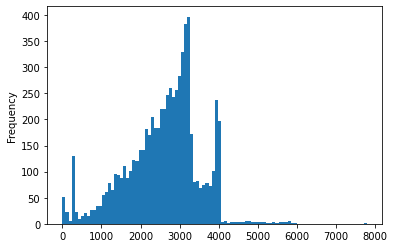

In [10]:
df['Size'].plot(kind='hist',bins=100)

In [11]:
df[(df['Size'] < 200) & (df['Size'] > 100)].sort_values(by=['Size'])

,PI Name,Abstracts,Size
2754,"Lorbeer, Mathias",Investigating links between intrauterine growt...,109
1789,"Geidelberg, Lily",Evaluating the contribution of key populations...,109
4019,"Khan, Azalea",The final aim is to prove that PET imaging tec...,113
1392,"Telford-Cooke, Leolie",Development of image-informatics approaches to...,117
1110,"Barasa, Sheila",Year 1 - MRes Translational Immunology followe...,126
2796,"Tsolova, Aleksandra",1st MSc project\nInvestigating the role of epi...,130
5071,"Osborn, Gabriel",Student will undertake 3 lab rotations before ...,132
5964,"Watt, Fiona",AE1: Molecular and cellular dermatology AE2: D...,139
3118,"Fonseca Pedro, Patricia",The aim of the investigation is to understand ...,141
3313,"Jones, Hannah",This project will investigate the roles of mem...,142


In [12]:
df = df[df['Size'] > 300]
df.shape

(6578, 3)

In [13]:
data = df['Abstracts'].values
data.shape

(6578,)

In [14]:
def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(text.maketrans('','', string.punctuation))
    tokens = word_tokenize(text)
 
    stop_words=stopwords.words('english')
    no_stop_words = []
    for token in tokens:
      if token not in stop_words:
        no_stop_words.append(token)

    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in no_stop_words]
 
    return tokens

In [15]:
data_pr = [process_text(abs) for abs in data]
data_pr = np.array(data_pr)
data_pr.shape

(6578,)

## **Stage 2:**  Feature Extraction 

### 3 Marks - > Create a representation of abstracts, convert it into vectors (numbers)

**Use any one** of the following algorithms for this task: TF-IDF or Doc2Vec

References Documents: 

1.   [TFIDFVectorizer](https://nlpforhackers.io/recipe-text-clustering/)
2.  [Doc2Vec 1](https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61) (or) [Doc2Vec 2](https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5)

In [20]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
import multiprocessing

# def doc2vec(in_data):
#     document_tagged = []
#     tagged_count = 0
#     for _ in in_data:
#         document_tagged.append(gensim.models.doc2vec.TaggedDocument(_,[tagged_count]))
#         tagged_count +=1 
#     d2v = Doc2Vec(document_tagged, size=300)
#     d2v.train(document_tagged,epochs=10,total_examples=d2v.corpus_count,)
#     print(d2v.epochs, d2v.corpus_count)
#     return d2v

# document_tagged = []
# tagged_count = 0
# for _ in data_pr:
#     document_tagged.append(TaggedDocument(_,[tagged_count]))
#     tagged_count +=1 

# d2v_model = Doc2Vec(document_tagged, size=300, alpha=0.025, min_alpha=0.025, train_lbls=False)
# d2v_model.build_vocab(document_tagged)
# for epoch in range(10):
#     d2v_model.train(document_tagged)
#     d2v_model.alpha -= 0.002  # decrease the learning rate
#     d2v_model.min_alpha = model.alpha  # fix the learning rate, no decay

In [67]:
cores = multiprocessing.cpu_count()

document_tagged = []
tagged_count = 0
for _ in data_pr:
  document_tagged.append(TaggedDocument(_,[tagged_count]))
  tagged_count +=1

model = Doc2Vec(vector_size=300, negative=5, hs=0, min_count=2, sample = 0, \
                workers=cores,alpha=0.025, min_alpha=0.025, train_lbls=False)
model.build_vocab([x for x in document_tagged])

In [68]:
%%time
from sklearn import utils
for epoch in range(30):
    model.train(utils.shuffle([x for x in document_tagged]), total_examples=len(document_tagged), epochs=1)
    model.alpha -= 0.002
    model.min_alpha = model.alpha

CPU times: user 4min 27s, sys: 2.1 s, total: 4min 29s
Wall time: 2min 20s


In [69]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=30)) for doc in sents])
    return np.array(regressors)

In [70]:
X_train = vec_for_learning(model, document_tagged)

In [71]:
X_train.shape

(6578, 300)

## **Stage 3:**  Kmeans clustering
Perform Kmeans clustering for the abstracts

### 2 Marks - > Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/). 

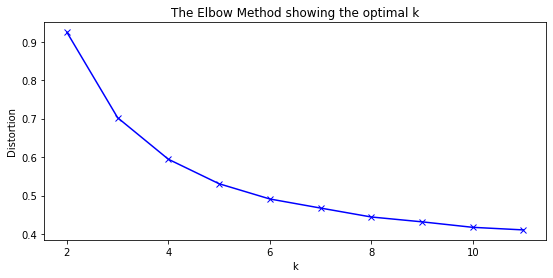

CPU times: user 1min 5s, sys: 31.4 s, total: 1min 36s
Wall time: 58.1 s


In [72]:
#YOUR CODE HERE
%%time
distortions = []
X = X_train
K = range(2,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(pairwise_distances(X, Y=kmeanModel.cluster_centers_, metric='euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.figure(figsize=(9,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### 2 Marks - > Apply Kmeans clustering with the optimal number of clusters. 

In [86]:
#YOUR CODE HERE
n_clusters = 4
km_model = KMeans(n_clusters, random_state=4)
km_model.fit(X_train)

clustering = collections.defaultdict(list)

for idx, label in enumerate(km_model.labels_):
    clustering[label].append(idx)

In [87]:
prediction = km_model.predict(X_train)

### 3 Marks - > Visualize the top frequent words in any 5 clusters' abstracts, using a [word cloud](https://programmerbackpack.com/word-cloud-python-tutorial-create-wordcloud-from-text/) approach. 

#### This will allow you to identify the research areas in the different clusters, based on the most frequently occurring words

Cluster  0


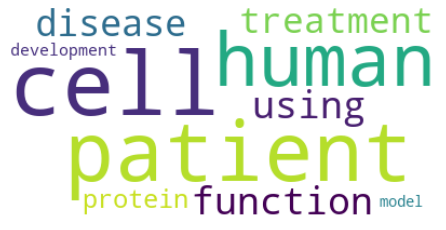

Cluster  1


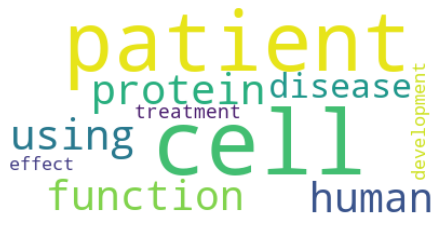

Cluster  2


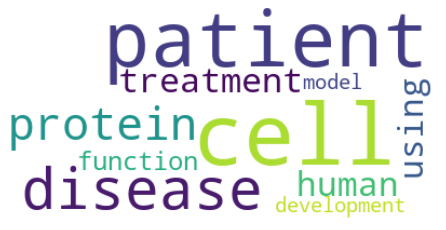

Cluster  3


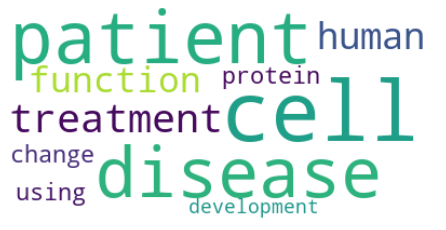

In [88]:
#YOUR CODE HERE
from wordcloud import WordCloud
for i in range(n_clusters):
  cluster = ''
  for idx in clustering[i]:
    cluster += data[idx]

  cloud = WordCloud(background_color='white',max_words=10).generate(cluster)
  # plt.figure(figsize=(9,4))
  plt.imshow(cloud, interpolation="bilinear")
  print('Cluster ', i)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

## **Stage 4:**  Testing Evaluation for TF-IDF/Doc2Vec



1.   Load the Test data and apply pre-processing steps
2.   Extract features of Test data



In [76]:
#YOUR CODE HERE to load the Test data and apply pre-processing
test_df = pd.read_csv('Test_Data.csv')
test_df = test_df[['PI Name', 'Abstracts']]
test_data = test_df['Abstracts'].values
test_data.shape

(343,)

In [77]:
test_tagged = []
tagged_count = 0
for _ in test_data:
  test_tagged.append(TaggedDocument(_,[tagged_count]))
  tagged_count +=1

X_test = vec_for_learning(model, test_tagged)
X_test.shape

(343, 300)

#### Two functions are defined below, to find the accuracy for Test data based on TF-IDF or Doc2Vec features

**Decription of below defined functions:**

*  Predicts label 'l' (i.e. cluster number) for each test item (i.e. research abstract) in the test data
*  For each of the test items, find the 10 nearest items [ n1,n2...n10 ] using TF-IDF or Doc2Vec similarity score and predict the labels (cluster number) of those nearest items with k-means [ l1,l2...l10 ] 
*  By comparing the test item label 'l' with nearest labels [ l1,l2..l10 ] accuracy is calculated for each test item
* Considers the average accuracy among test items
<br><br>
Accuracy = sum of all accuracies / no.of items

### 2 Marks - > Obtain the accuracy for TF-IDF/Doc2Vec based clustering

In [65]:
def get_accuracy_for_Doc2Vec(train_features,test_features,kmeans_model,d2v_model):
  accuracies=[]
  train_features=np.array(train_features)
  test_features=np.array(test_features)
  for t in test_features:
    t=np.array(t).reshape(1,-1)
    T_sim=d2v_model.docvecs.most_similar(t)
    pred=kmeans_model.predict(t)[0]
    ac=0
    for i in T_sim:
      if kmeans_model.predict(train_features[i[0]].reshape(1,-1))==pred:
        ac+=1
    accuracies.append(ac*10)
  return sum(accuracies)/test_features.shape[0]

In [ ]:
def get_accuracy_for_TFIDF(train_features,test_features,kmeans_model):
  accuracies=[]
  for t in test_features:
    dist=cosine_similarity(train_features,t)
    sorted_dist=sorted(dist,reverse=True)
    indx=[np.where(dist==i)[0][0] for i in sorted_dist[:10]]
    pred=kmeans_model.predict(t)[0]
    ac=0
    for i in indx:
      if kmeans_model.predict(train_features[i])[0]==pred:
        ac+=1
    accuracies.append(ac*len(indx))
  return sum(accuracies)/test_features.shape[0]

In [78]:
# YOUR CODE HERE to call the appropriate function based on your feature extraction.
get_accuracy_for_Doc2Vec(X_train,X_test,km_model,model)

99.94169096209913

In [85]:
# YOUR CODE HERE to call the appropriate function based on your feature extraction.
get_accuracy_for_Doc2Vec(X_train,X_test,km_model,model)

89.94169096209913

In [89]:
# YOUR CODE HERE to call the appropriate function based on your feature extraction.
get_accuracy_for_Doc2Vec(X_train,X_test,km_model,model)

89.94169096209913

## **Stage 5:**  Deriving Insights


### 1 Marks - > List the PI names in each cluster

In [79]:
#YOUR CODE HERE
pi_names = collections.defaultdict(list)

for idx, label in enumerate(km_model.labels_):
    clustering[label].append(idx)

for i in range(len(clustering)):
  for idx in clustering[i]:
    pi_names[i].append(df.iloc[idx]['PI Name'])

In [80]:
len(data), len(clustering[0]), len(pi_names[0]), len(set(pi_names[0]))

(6578, 3494, 3494, 1721)

In [81]:
for i in range(len(pi_names)):
  print(f'PI Names in Cluster {i}: {pi_names[i][:5]}')

PI Names in Cluster 0: ['Jernigan, Valarie J', 'Barlow, Mary Allison', 'Abu Sittah, Ghassan', 'Mardon, Graeme', 'Forest, Katrina T']
PI Names in Cluster 1: ['Fitches, Molly', 'Marsh, Kevin', 'Shroff, Hari', 'Bozhilova, Natali', 'Smith, Ken']
PI Names in Cluster 2: ['Lumbers, Richard', 'Limb, Gloria', 'Elcocks, Hannah', 'Gur, Raquel E', 'Haake, David A']


### 2 Marks - > Give a research topic search term and map which cluster it belongs to

Hint: Take any short query from the data for the search item

In [ ]:
#YOUR CODE HERE

### 2 Marks - > Within the cluster, map to the top principal investigators (PI names) most relevant to that search term. Possible approaches: Doc2Vec similarity score/ cosine similarity between documents.

In [ ]:
#YOUR CODE HERE

### (Optional): Identify the top funded research investigators most relevant to the search term

In [ ]:
#YOUR CODE HERE